### *1. Импорты + Распаковка TAR*

In [1]:
import os
import tarfile
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, jaccard_score

from skimage.feature import graycomatrix, graycoprops

In [2]:
tar_path = "/content/drive/MyDrive/kth_tips_grey_200x200.tar"
dest_dir = "./data"

os.makedirs(dest_dir, exist_ok=True)

with tarfile.open(tar_path) as tar:
    tar.extractall(dest_dir)

print("Файлы успешно распакованы в ./data")

/tmp/ipython-input-1140829618.py:7: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(dest_dir)


Файлы успешно распакованы в ./data


### *2. Загрузка датасета KTH-TIPS*

In [3]:
def load_kth_tips(root):
    X, y = [], []

    for class_name in sorted(os.listdir(root)):
        class_dir = os.path.join(root, class_name)
        if not os.path.isdir(class_dir):
            continue

        for fname in os.listdir(class_dir):
            if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
                continue

            path = os.path.join(class_dir, fname)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            img = cv2.resize(img, (128, 128))
            X.append(img)
            y.append(class_name)

    return np.array(X), np.array(y)

dataset_root = "./data/KTH_TIPS"
X_imgs, y_labels = load_kth_tips(dataset_root)

print("Загружено изображений:", len(X_imgs))
print("Классов:", len(np.unique(y_labels)))

Загружено изображений: 810
Классов: 10


### *3. Признаки: Гистограмма*

In [4]:
def hist_features(img, bins=256):
    hist = cv2.calcHist([img], [0], None, [bins], [0,256]).flatten()
    hist = hist / hist.sum()

    values = np.arange(256)

    mean = np.sum(hist * values)
    var = np.sum(hist * (values - mean)**2)
    std = np.sqrt(var)

    skew = np.sum(hist * ((values - mean)/(std+1e-8))**3)
    kurt = np.sum(hist * ((values - mean)/(std+1e-8))**4) - 3

    nz = hist[hist > 0]
    entropy = -np.sum(nz * np.log2(nz))

    q1 = np.argmax(np.cumsum(hist) >= 0.25)
    q2 = np.argmax(np.cumsum(hist) >= 0.50)
    q3 = np.argmax(np.cumsum(hist) >= 0.75)

    nz_bins = np.where(hist > 0)[0]
    min_bin = nz_bins[0] if len(nz_bins) else 0
    max_bin = nz_bins[-1] if len(nz_bins) else 255

    return np.array([mean, std, skew, kurt, entropy, q1, q2, q3, min_bin, max_bin])

### *4. Признаки: Laws Texture*

In [5]:
def laws_features(img):
    L5 = np.array([1,4,6,4,1])
    E5 = np.array([-1,-2,0,2,1])
    S5 = np.array([-1,0,2,0,-1])
    W5 = np.array([-1,2,0,-2,1])
    R5 = np.array([1,-4,6,-4,1])

    masks = [L5,E5,S5,W5,R5]
    feats = []

    for a in masks:
        for b in masks:
            kernel = np.outer(a,b)
            f = cv2.filter2D(img.astype(np.float32), -1, kernel)
            feats.append(np.mean(f**2))

    feats = np.array(feats)
    return feats / feats.sum()

5. Признаки: GLCM

In [6]:
def glcm_features(img):
    small = (img // 8).astype(np.uint8)
    glcm = graycomatrix(small,
                        distances=[1],
                        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=32, symmetric=True, normed=True)

    props = ["contrast","dissimilarity","homogeneity","energy","correlation"]
    feats = [np.mean(graycoprops(glcm, p)) for p in props]
    return np.array(feats)

### *6. Формирование матриц признаков*

In [7]:
X_hist = np.array([hist_features(img) for img in X_imgs])
X_laws = np.array([laws_features(img) for img in X_imgs])
X_glcm = np.array([glcm_features(img) for img in X_imgs])

print(X_hist.shape, X_laws.shape, X_glcm.shape)

(810, 10) (810, 25) (810, 5)


### *7. Обучение моделей*

In [8]:
models = {
    "kNN": KNeighborsClassifier(n_neighbors=3),
    "SVM": SVC(kernel="rbf"),
    "Tree": DecisionTreeClassifier(max_depth=10)
}

enc = LabelEncoder()
y_encoded = enc.fit_transform(y_labels)

all_features = {
    "Histogram": X_hist,
    "Laws": X_laws,
    "GLCM": X_glcm
}

trained = {}

for name, X in all_features.items():
    print("\n###", name)

    if X.shape[0] == 0:
        print(f"Пропускаем {name}: массив признаков пустой")
        continue
    if X.shape[0] != len(y_encoded):
        print(f"Пропускаем {name}: количество образцов ({X.shape[0]}) не совпадает с количеством меток ({len(y_encoded)})")
        continue

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
    )

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    trained[name] = {}

    for mname, model in models.items():
        model.fit(X_train_s, y_train)
        pred = model.predict(X_test_s)

        print("\n", name, "+", mname)
        print(classification_report(y_test, pred, target_names=enc.classes_))

        trained[name][mname] = (model, scaler)


### Histogram

 Histogram + kNN
                precision    recall  f1-score   support

aluminium_foil       1.00      1.00      1.00        20
   brown_bread       0.89      0.85      0.87        20
      corduroy       0.74      0.85      0.79        20
        cotton       0.76      0.76      0.76        21
       cracker       0.94      0.81      0.87        21
         linen       0.85      0.85      0.85        20
   orange_peel       0.90      0.90      0.90        21
     sandpaper       0.76      0.80      0.78        20
        sponge       0.91      1.00      0.95        20
     styrofoam       1.00      0.90      0.95        20

      accuracy                           0.87       203
     macro avg       0.88      0.87      0.87       203
  weighted avg       0.88      0.87      0.87       203


 Histogram + SVM
                precision    recall  f1-score   support

aluminium_foil       1.00      1.00      1.00        20
   brown_bread       0.95      1.00      0.98    

### *8. Сегментация хлеба*

In [9]:
def segment_image(model_tuple, method_name, img_path, patch=32, step=8):
    model, scaler = model_tuple
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    H, W = img.shape

    mask = np.zeros((H,W), dtype=np.uint8)

    for y in range(0, H - patch + 1, step):
        for x in range(0, W - patch + 1, step):
            block = img[y:y+patch, x:x+patch]

            if "Histogram" in method_name:
                f = hist_features(block)
            elif "Laws" in method_name:
                f = laws_features(block)
            else:
                f = glcm_features(block)

            f_s = scaler.transform(f.reshape(1, -1))
            pred = model.predict(f_s)[0]

            mask[y:y+patch, x:x+patch] = pred

    return mask

### *9. Сегментация Laws + SVM*

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(
    X_laws, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

model = SVC(kernel="rbf")
model.fit(X_train_s, y_train)
trained["Laws"] = {"SVM": (model, scaler)}

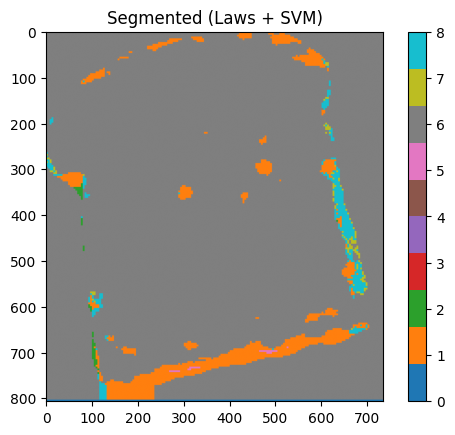

In [11]:
pred_mask = segment_image(
    trained["Laws"]["SVM"], "Laws", "bread_gray.jpg",
    patch=32, step=4
)

plt.imshow(pred_mask, cmap="tab10")
plt.title("Segmented (Laws + SVM)")
plt.colorbar()
plt.show()

### *10. Загрузка разметки и сравнение*

Классы в ручной разметке: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  43  51  54 201 208 209 212 216 218 219 220 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252 253 254 255]


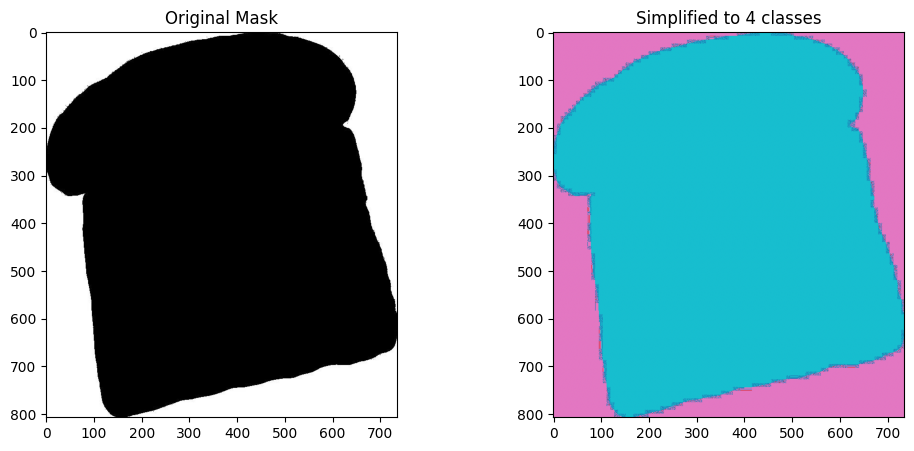

In [12]:
true_mask = cv2.imread("bread_mask.jpg", cv2.IMREAD_GRAYSCALE)

uniq = np.unique(true_mask)
print("Классы в ручной разметке:", uniq)

def simplify(mask, n=4):
    vals, cnt = np.unique(mask, return_counts=True)
    top = vals[np.argsort(cnt)[-n:]]
    out = np.zeros_like(mask)
    for i,v in enumerate(top):
        out[mask==v] = i
    return out

true4 = simplify(true_mask)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(true_mask, cmap="gray")
plt.title("Original Mask")

plt.subplot(1,2,2)
plt.imshow(true4, cmap="tab10")
plt.title("Simplified to 4 classes")
plt.show()

### *11. Итоговое сравнение по Accuracy и IoU*

Accuracy: 0.002813358655244868
Class 0 IoU = 0.000
Class 1 IoU = 0.011
Class 2 IoU = 0.009
Class 3 IoU = 0.000


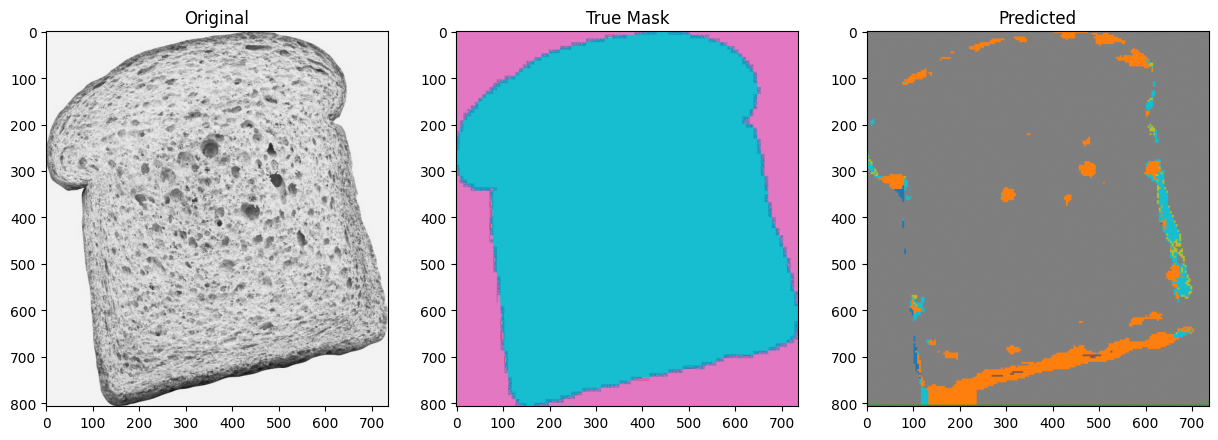

In [13]:
mapping = {0:3, 1:2, 2:1, 3:0}

pred_renum = pred_mask.copy()
for k,v in mapping.items():
    pred_renum[pred_mask == k] = v

acc = accuracy_score(true4.flatten(), pred_renum.flatten())
print("Accuracy:", acc)

for cls in np.unique(true4):
    iou = jaccard_score(true4.flatten(), pred_renum.flatten(),
                        labels=[cls], average=None)[0]
    print(f"Class {cls} IoU = {iou:.3f}")

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(cv2.imread("bread_gray.jpg",0), cmap="gray")
plt.title("Original")

plt.subplot(1,3,2)
plt.imshow(true4, cmap="tab10")
plt.title("True Mask")

plt.subplot(1,3,3)
plt.imshow(pred_renum, cmap="tab10")
plt.title("Predicted")
plt.show()